In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update(
    {
        "text.usetex": True,
        "axes.labelsize": 20,
        "figure.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "figure.constrained_layout.wspace": 0,
        "figure.constrained_layout.hspace": 0,
        "figure.constrained_layout.h_pad": 0,
        "figure.constrained_layout.w_pad": 0,
        "axes.linewidth": 1.3,
    }
)

import jax
import jax.numpy as jnp

# you should always set this
jax.config.update("jax_enable_x64", True)

## Damped Harmonic Oscillator (DHO) Fitting
This notebook demonstrate how to fit a DHO process to a single-band light curve. Please see notebook [01_MultibandFitting](01_MultibandFitting.ipynb) for a tutorial on fitting multiband light curves.

**Note:**
The CARMA autoregressive parameter notation follows the covention of [Kelly+14](https://arxiv.org/abs/1402.5978).

### 1. Light Curve Simulation

In [2]:
from eztao.carma import DHO_term
from eztao.ts import addNoise, gpSimRand

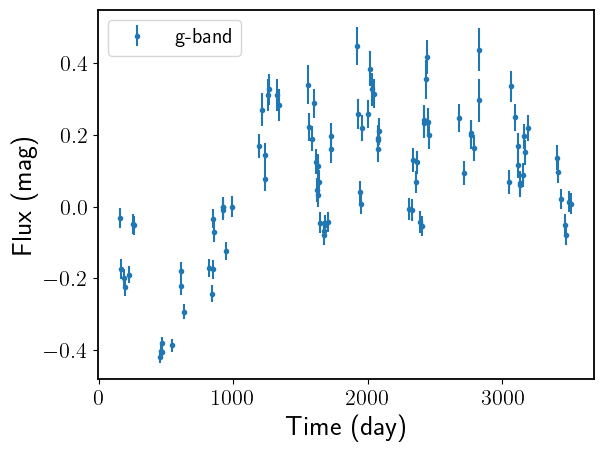

In [3]:
# CARMA(2,1)/DHO parameters
alphas = {"g": [0.05, 0.0002]}
betas = {"g": [0.0006, 0.03]}

# simulation configureations
snrs = {"g": 5}
sampling_seeds = {"g": 2}
noise_seeds = {"g": 11}
lags = {"g": 0}
bands = "g"
n_yr = 10

ts, ys, yerrs = {}, {}, {}
ys_noisy = {}
seed = 2
for band in bands:
    DHO_kernel = DHO_term(*np.log(alphas[band]), *np.log(betas[band]))
    t, y, yerr = gpSimRand(
        DHO_kernel,
        snrs[band],
        365 * n_yr,  # 10 year LC
        100,
        lc_seed=seed,
        downsample_seed=sampling_seeds[band],
    )

    # add to dict
    ts[band] = t
    ys[band] = y
    yerrs[band] = yerr
    # add simulated photometric noise
    ys_noisy[band] = addNoise(ys[band], yerrs[band], seed=noise_seeds[band] + seed)

for b in bands:
    plt.errorbar(
        ts[b][::1], ys_noisy[b][::1], yerrs[b][::1], fmt=".", label=f"{b}-band"
    )

plt.xlabel("Time (day)")
plt.ylabel("Flux (mag)")
plt.legend(fontsize=15)

### 2. Fitting
Here, we demonstrate how to use the `UniVarModel` for fitting single-band light curves.

In [4]:
import numpyro
import numpyro.distributions as dist
from eztaox.fitter import random_search
from eztaox.kernels.quasisep import CARMA
from eztaox.models import UniVarModel
from numpyro.handlers import seed as numpyro_seed

#### 2.1 Initialize Light Curve Model

In [5]:
zero_mean = False
p = 2  # CARMA p-order
test_params = {"log_kernel_param": jnp.log(np.array([0.1, 1.1, 1.0, 3.0]))}

# define kernel
k = CARMA.init(
    jnp.exp(test_params["log_kernel_param"][:p]),
    jnp.exp(test_params["log_kernel_param"][p:]),
)

# define univar model
m = UniVarModel(ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean)
m

UniVarModel(
  X=(f64[100], i64[100]),
  y=f64[100],
  diag=f64[100],
  base_kernel_def=<jax._src.util.HashablePartial object at 0xffff3db3dac0>,
  multiband_kernel=<class 'eztaox.kernels.quasisep.MultibandLowRank'>,
  nBand=1,
  mean_func=None,
  amp_scale_func=None,
  lag_func=None,
  zero_mean=False,
  has_jitter=False,
  has_lag=False
)

#### 2.2 Define InitSampler

In [6]:
def initSampler():
    # DHO Alpha & Beta parameters
    log_alpha = numpyro.sample(
        "log_alpha", dist.Uniform(low=-16.0, high=0.0).expand([2])
    )
    log_beta = numpyro.sample("log_beta", dist.Uniform(low=-10.0, high=2.0).expand([2]))

    log_kernel_param = jnp.hstack([log_alpha, log_beta])
    numpyro.deterministic("log_kernel_param", log_kernel_param)

    # mean
    mean = numpyro.sample("mean", dist.Uniform(low=-0.2, high=0.2))

    sample_params = {"log_kernel_param": log_kernel_param, "mean": mean}
    return sample_params

In [7]:
# generate a random initial guess
sample_key = jax.random.PRNGKey(1)
prior_sample = numpyro_seed(initSampler, rng_seed=sample_key)()
prior_sample

{'log_kernel_param': Array([ -4.87392318, -13.69996053,  -3.87823238,  -6.84304299], dtype=float64),
 'mean': Array(-0.06222013, dtype=float64)}

#### 2.3 MLE Fitting

In [8]:
%%time
model = m
sampler = initSampler
fit_key = jax.random.PRNGKey(1)
nSample = 10_000
nBest = 10  # it seems like this number needs to be high

bestP, ll = random_search(model, initSampler, fit_key, nSample, nBest)
bestP

CPU times: user 1.99 s, sys: 94.2 ms, total: 2.08 s
Wall time: 2.02 s


{'log_kernel_param': Array([-9.18107731, -2.83734073, -7.38433175, -3.38352044], dtype=float64),
 'mean': Array(0.04086568, dtype=float64)}

In [9]:
# True DHO param
# Note that EzTao follows the CARMA notation from Moreno+19,
# and EzTaoX adopts the CARMA notation from Kelly+14.
# The main difference is that the alpha parameter index is reversed.
print("True DHO Params (in natual log):")
print(np.log(np.hstack([alphas["g"][::-1], betas["g"]])))
print("MLE DHO Params (in natual log):")
print(bestP["log_kernel_param"])

True DHO Params (in natual log):
[-8.51719319 -2.99573227 -7.4185809  -3.5065579 ]
MLE DHO Params (in natual log):
[-9.18107731 -2.83734073 -7.38433175 -3.38352044]


### 3. MCMC

In [10]:
import arviz as az
from numpyro.infer import MCMC, NUTS

In [11]:
def numpyro_model(t, yerr, y=None):
    log_alpha = numpyro.sample(
        "log_alpha", dist.Uniform(low=-16.0, high=0.0).expand([2])
    )
    log_beta = numpyro.sample("log_beta", dist.Uniform(low=-10.0, high=2.0).expand([2]))

    log_kernel_param = jnp.hstack([log_alpha, log_beta])
    numpyro.deterministic("log_kernel_param", log_kernel_param)

    # mean: use a normal prior for better convergence
    mean = numpyro.sample("mean", dist.Normal(0.0, 0.1))

    sample_params = {"log_kernel_param": log_kernel_param, "mean": mean}

    # the following is different from the initSampler
    zero_mean = False
    p = 2

    k = CARMA.init(
        jnp.exp(test_params["log_kernel_param"][:p]),
        jnp.exp(test_params["log_kernel_param"][p:]),
    )
    m = UniVarModel(ts["g"], ys_noisy["g"], yerrs["g"], k, zero_mean=zero_mean)
    m.sample(sample_params)

In [12]:
%%time
nuts_kernel = NUTS(
    numpyro_model,
    dense_mass=True,
    target_accept_prob=0.9,
    init_strategy=numpyro.infer.init_to_sample,
)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=1,
    # progress_bar=False,
)

mcmc_seed = 0
mcmc.run(jax.random.PRNGKey(mcmc_seed), ts["g"], yerrs["g"], y=ys_noisy["g"])
data = az.from_numpyro(mcmc)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:05<00:00, 1080.39it/s, 15 steps of size 1.43e-01. acc. prob=0.95]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
log_alpha[0]    -10.35      2.12    -10.17    -13.82     -6.45    505.36      1.00
log_alpha[1]     -2.80      0.88     -2.92     -4.26     -1.32    456.16      1.00
 log_beta[0]     -7.40      1.16     -7.52     -9.52     -5.54    470.65      1.00
 log_beta[1]     -3.35      0.22     -3.38     -3.70     -3.02    560.18      1.00
        mean      0.01      0.09      0.02     -0.12      0.15   2552.89      1.00

Number of divergences: 0
CPU times: user 8.34 s, sys: 201 ms, total: 8.54 s
Wall time: 8.49 s


#### Visualize Chains, Posterior Distributions

In [13]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

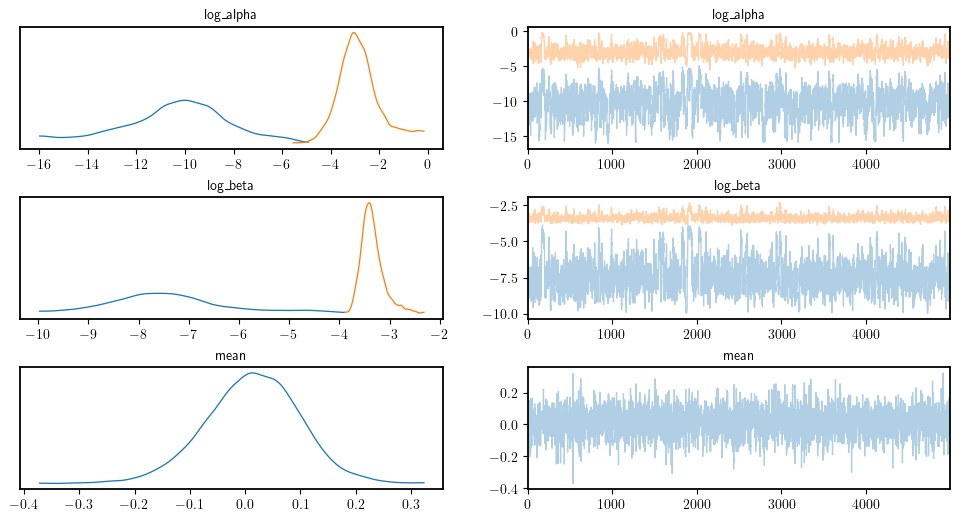

In [14]:
az.plot_trace(data, var_names=["log_alpha", "log_beta", "mean"])
plt.subplots_adjust(hspace=0.4)

array([[<Axes: ylabel='log_alpha\n1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_beta\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_beta\n1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='log_alpha\n0', ylabel='mean'>,
        <Axes: xlabel='log_alpha\n1'>, <Axes: xlabel='log_beta\n0'>,
        <Axes: xlabel='log_beta\n1'>]], dtype=object)

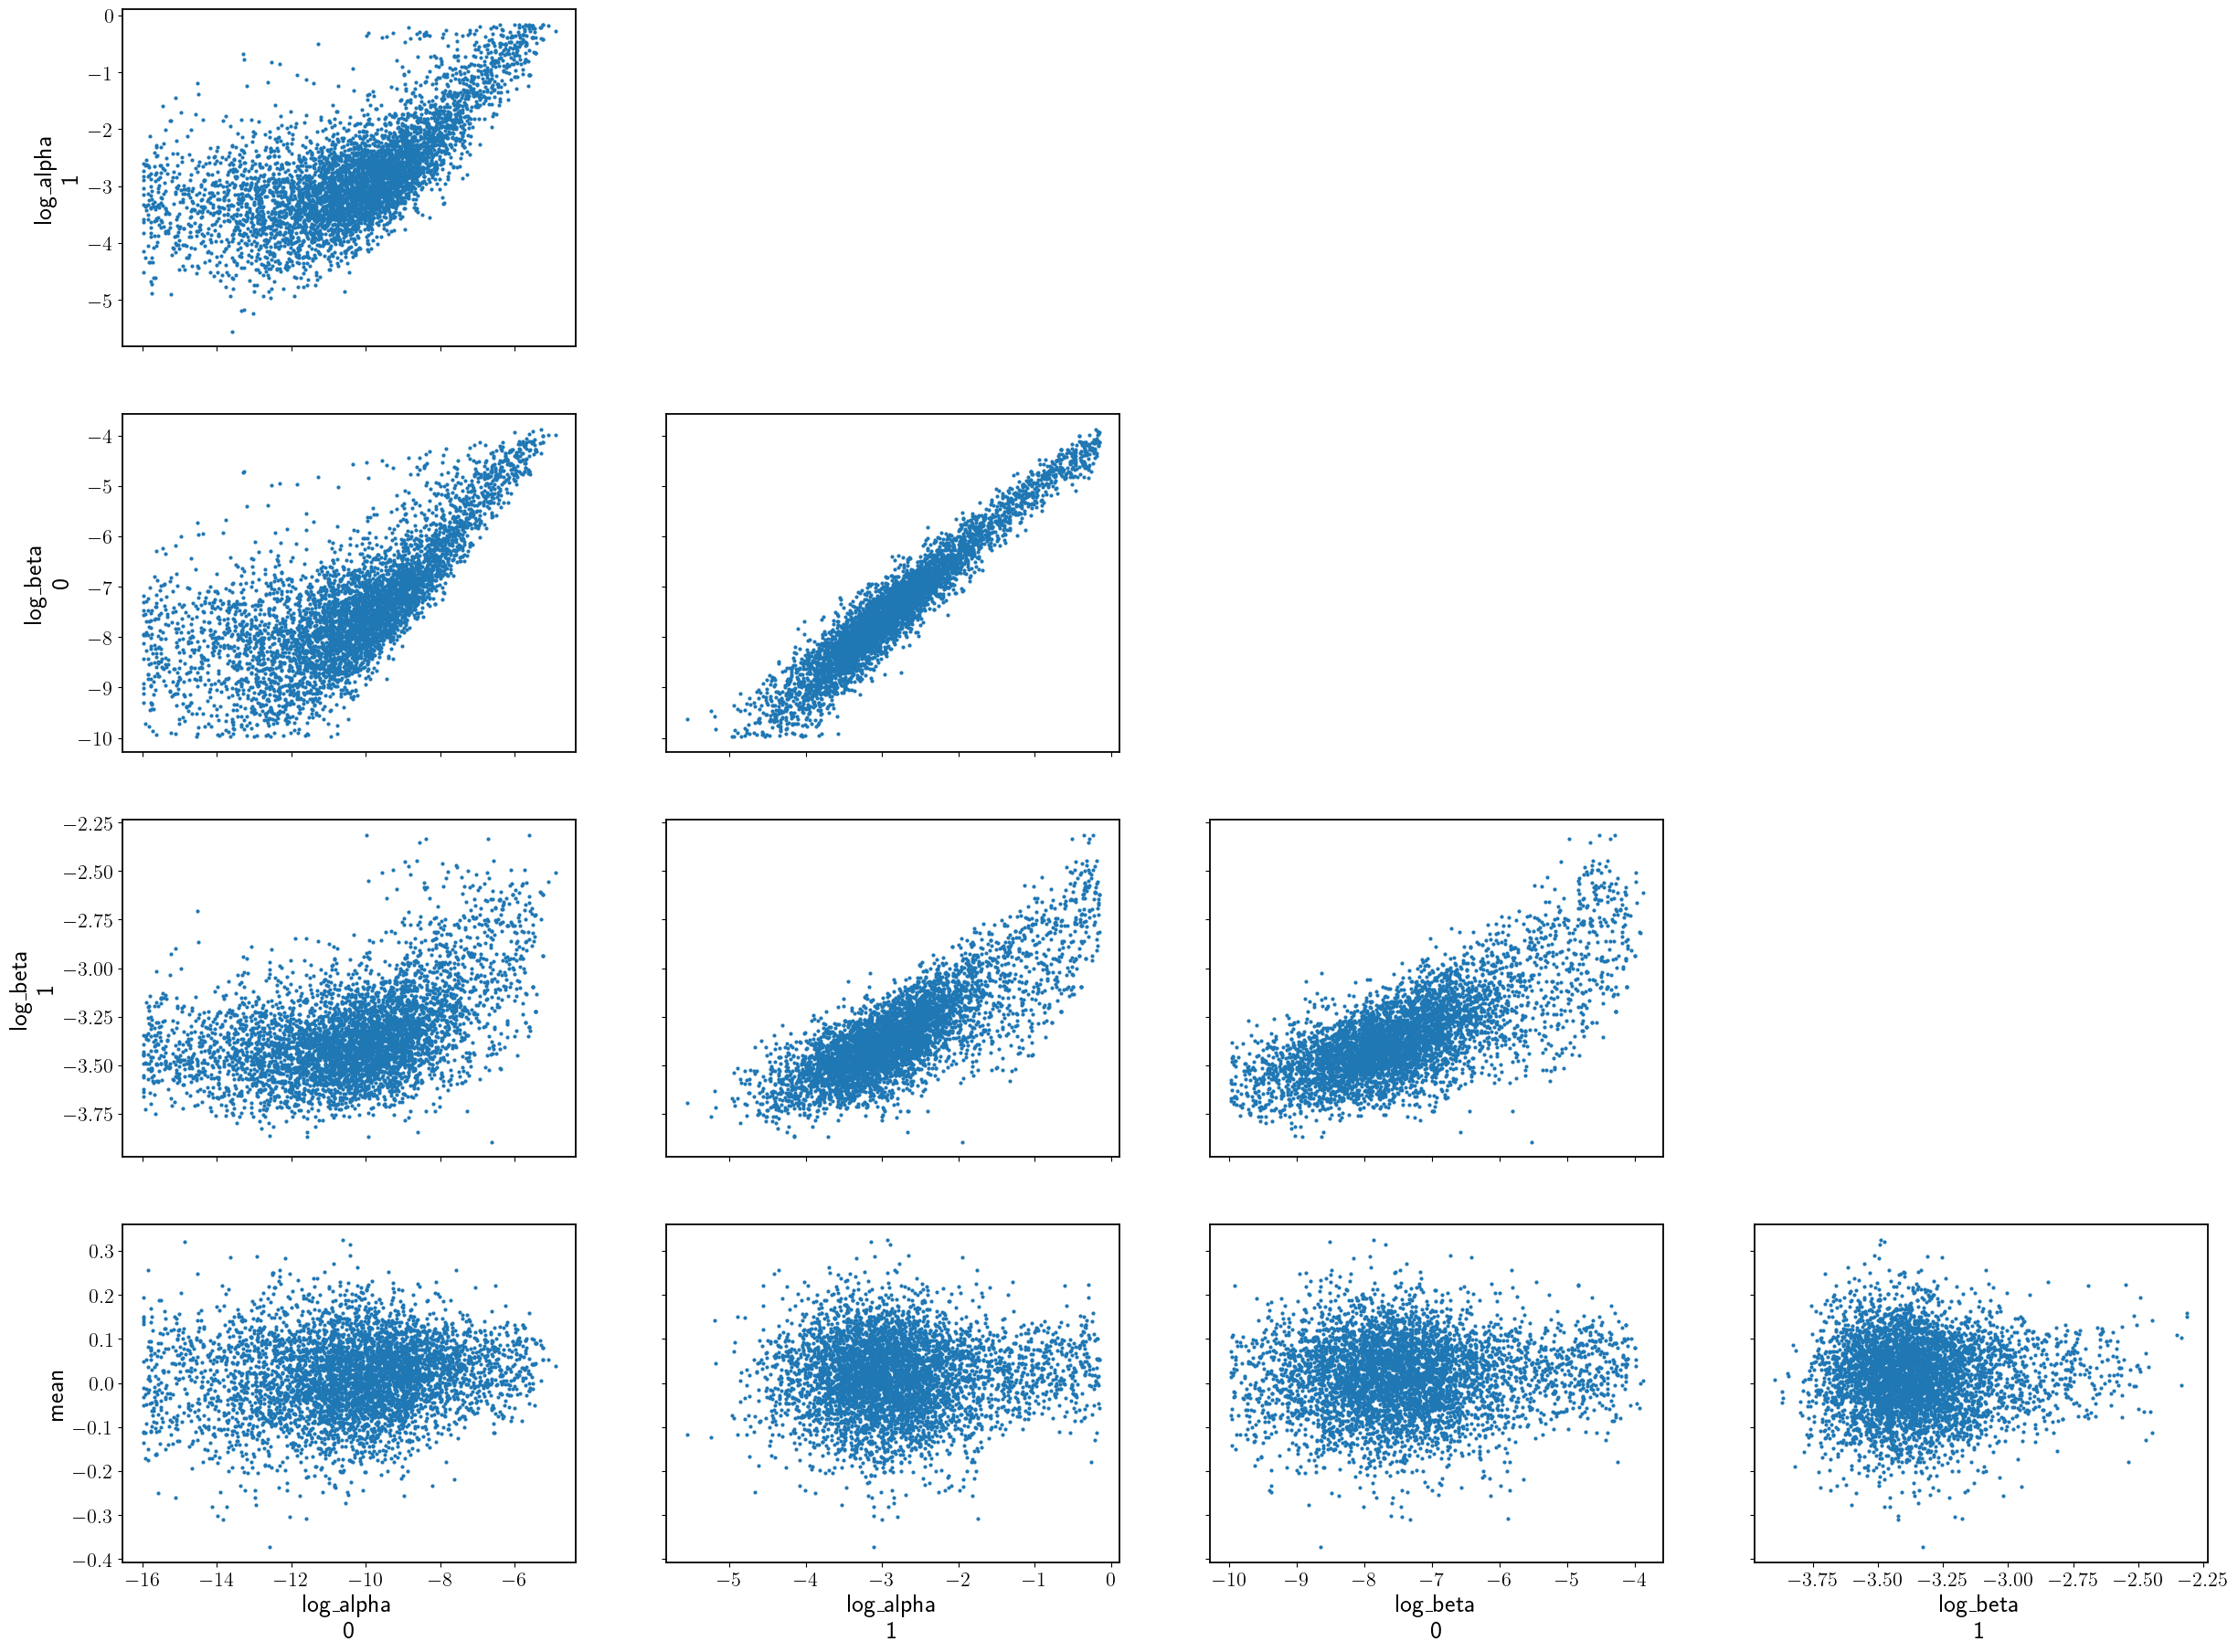

In [15]:
az.plot_pair(data, var_names=["log_alpha", "log_beta", "mean"])

### 4. Second-order Statistics

In [16]:
from eztaox.kernel_stat2 import gpStat2

ts = np.logspace(0, 4)
fs = np.logspace(-4, 0)

In [17]:
# get MCMC samples
flatPost = data.posterior.stack(sample=["chain", "draw"])
log_carma_draws = flatPost["log_kernel_param"].values.T

In [18]:
# create second-order stat object
dho_k = CARMA.init(alphas["g"][::-1], betas["g"])
gpStat2_dho = gpStat2(dho_k)

#### 4.1 Structure Function

In [19]:
# compute sf for MCMC draws
mcmc_sf = jax.vmap(gpStat2_dho.sf, in_axes=(None, 0))(ts, jnp.exp(log_carma_draws))

Text(0, 0.5, 'SF')

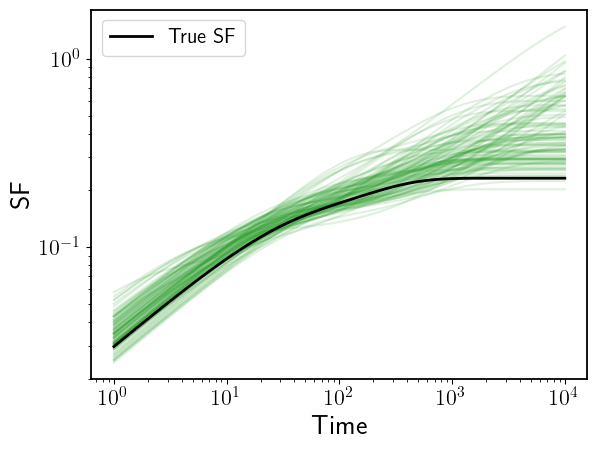

In [20]:
## plot
# ture SF
plt.loglog(ts, gpStat2_dho.sf(ts), c="k", label="True SF", zorder=100, lw=2)
plt.legend(fontsize=15)
# MCMC SFs
for sf in mcmc_sf[::50]:
    plt.loglog(ts, sf, c="tab:green", alpha=0.15)

plt.xlabel("Time")
plt.ylabel("SF")

#### 4.1 Power Spectral Density (PSD)

In [21]:
# compute sf for MCMC draws
mcmc_psd = jax.vmap(gpStat2_dho.psd, in_axes=(None, 0))(fs, jnp.exp(log_carma_draws))

Text(0, 0.5, 'PSD')

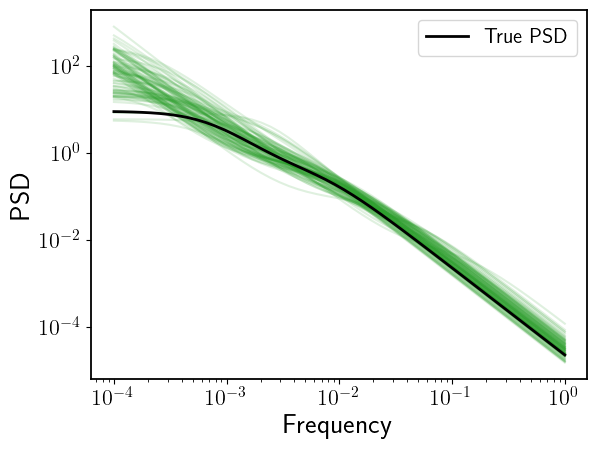

In [22]:
## plot
# ture PSD
plt.loglog(fs, gpStat2_dho.psd(fs), c="k", label="True PSD", zorder=100, lw=2)
plt.legend(fontsize=15)

# MCMC PSDs
for psd in mcmc_psd[::50]:
    plt.loglog(fs, psd, c="tab:green", alpha=0.15)

plt.xlabel("Frequency")
plt.ylabel("PSD")